=== SETUP ===
Device: cpu

=== LOADING DATA ===
Test samples: 317

=== LOADING TRAINED MODEL ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully

=== MAKING PREDICTIONS ===


Predicting: 100%|██████████| 20/20 [01:46<00:00,  5.33s/it]



=== CALCULATING METRICS ===

=== OVERALL METRICS ===
Accuracy:           0.7066
Precision (Weighted): 0.7067
Recall (Weighted):    0.7066
F1-Score (Weighted):  0.7066
Precision (Macro):    0.7067
Recall (Macro):       0.7066
F1-Score (Macro):     0.7066
ROC-AUC:            0.7969

=== PER-CLASS METRICS ===

Non-Cyberbullying:
  Precision: 0.7097
  Recall:    0.6962
  F1-Score:  0.7029
  Support:   158

Cyberbullying:
  Precision: 0.7037
  Recall:    0.7170
  F1-Score:  0.7103
  Support:   159

=== CONFUSION MATRIX ===
[[110  48]
 [ 45 114]]


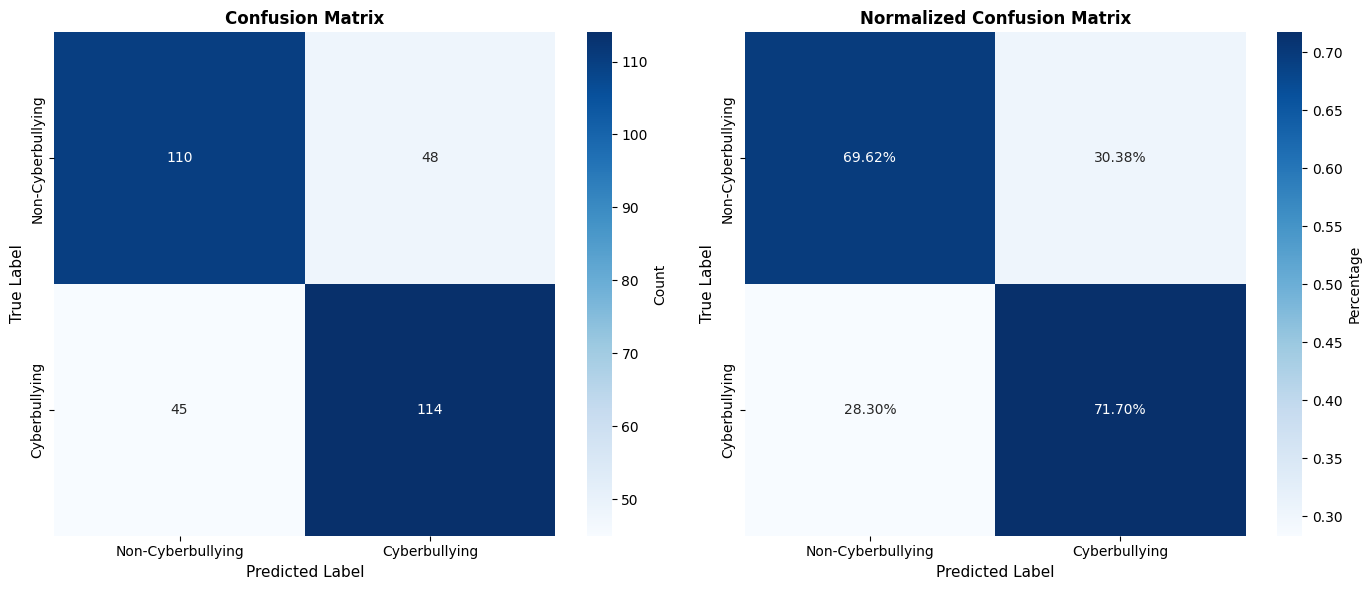


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

Non-Cyberbullying     0.7097    0.6962    0.7029       158
    Cyberbullying     0.7037    0.7170    0.7103       159

         accuracy                         0.7066       317
        macro avg     0.7067    0.7066    0.7066       317
     weighted avg     0.7067    0.7066    0.7066       317


=== ROC CURVE ===


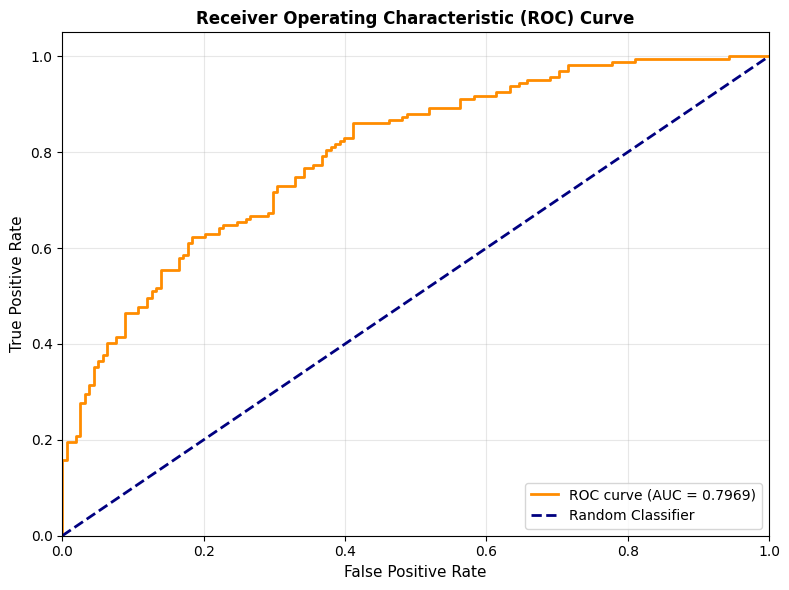


✓ Metrics saved to results/metrics/evaluation_metrics.csv


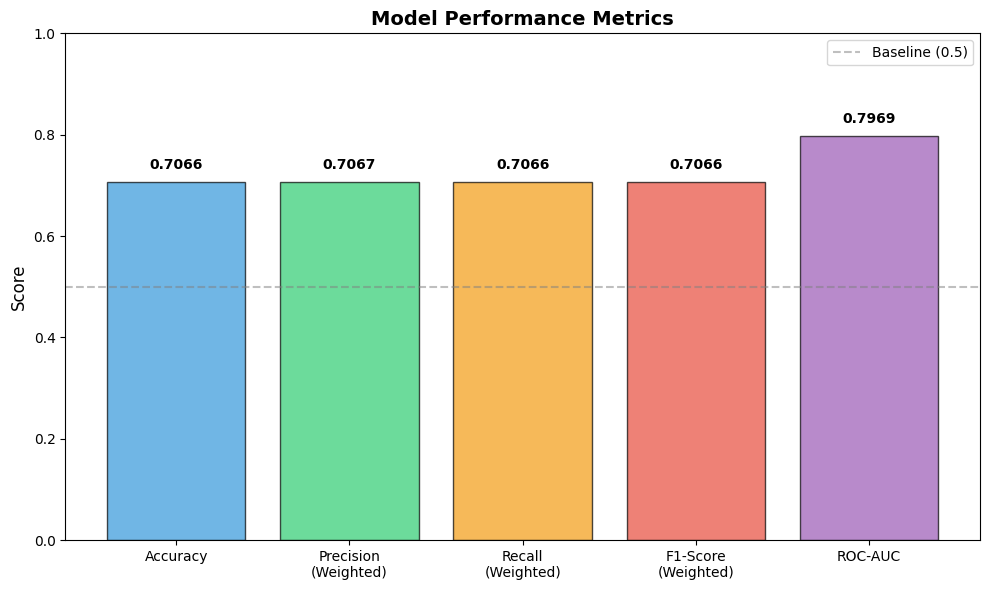

✓ Predictions saved to results/metrics/test_predictions.csv

=== EVALUATION SELESAI ===
Lanjutkan ke notebook 05_fairness_analysis.ipynb


In [1]:
"""
Notebook 4: Model Evaluation
Evaluasi menyeluruh model untuk publikasi jurnal
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===== SETUP =====
print("=== SETUP ===")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

MAX_LEN = 128
BATCH_SIZE = 16
MODEL_NAME = 'indobenchmark/indobert-base-p1'

# ===== LOAD DATA =====
print("\n=== LOADING DATA ===")
test_df = pd.read_csv('../data/processed/test.csv')
print(f"Test samples: {len(test_df)}")

# ===== DATASET CLASS =====
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ===== LOAD MODEL =====
print("\n=== LOADING TRAINED MODEL ===")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# Load best weights
model.load_state_dict(torch.load('../models/best_model.pt', map_location=device))
model = model.to(device)
model.eval()
print("✓ Model loaded successfully")

# ===== CREATE TEST DATALOADER =====
test_dataset = CyberbullyingDataset(
    texts=test_df['cleaned_comment'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===== PREDICTION FUNCTION =====
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            
            _, preds = torch.max(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            prediction_probs.extend(probs.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(prediction_probs), np.array(real_values)

# ===== GET PREDICTIONS =====
print("\n=== MAKING PREDICTIONS ===")
y_pred, y_pred_probs, y_true = get_predictions(model, test_loader, device)

# ===== CALCULATE METRICS =====
print("\n=== CALCULATING METRICS ===")

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

# ROC-AUC
try:
    roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])
except:
    roc_auc = 0.0

print("\n=== OVERALL METRICS ===")
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted):    {recall:.4f}")
print(f"F1-Score (Weighted):  {f1:.4f}")
print(f"Precision (Macro):    {precision_macro:.4f}")
print(f"Recall (Macro):       {recall_macro:.4f}")
print(f"F1-Score (Macro):     {f1_macro:.4f}")
print(f"ROC-AUC:            {roc_auc:.4f}")

print("\n=== PER-CLASS METRICS ===")
class_names = ['Non-Cyberbullying', 'Cyberbullying']
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall:    {recall_per_class[i]:.4f}")
    print(f"  F1-Score:  {f1_per_class[i]:.4f}")
    print(f"  Support:   {support[i]}")

# ===== CONFUSION MATRIX =====
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
print(cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# Confusion Matrix (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== CLASSIFICATION REPORT =====
print("\n=== CLASSIFICATION REPORT ===")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Save report
with open('../results/metrics/classification_report.txt', 'w') as f:
    f.write(report)

# ===== ROC CURVE =====
if roc_auc > 0:
    print("\n=== ROC CURVE ===")
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/figures/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

# ===== METRICS COMPARISON TABLE =====
metrics_data = {
    'Metric': [
        'Accuracy',
        'Precision (Weighted)',
        'Recall (Weighted)',
        'F1-Score (Weighted)',
        'Precision (Macro)',
        'Recall (Macro)',
        'F1-Score (Macro)',
        'ROC-AUC',
        'Non-Cyber Precision',
        'Non-Cyber Recall',
        'Non-Cyber F1-Score',
        'Cyber Precision',
        'Cyber Recall',
        'Cyber F1-Score'
    ],
    'Value': [
        f"{accuracy:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{precision_macro:.4f}",
        f"{recall_macro:.4f}",
        f"{f1_macro:.4f}",
        f"{roc_auc:.4f}",
        f"{precision_per_class[0]:.4f}",
        f"{recall_per_class[0]:.4f}",
        f"{f1_per_class[0]:.4f}",
        f"{precision_per_class[1]:.4f}",
        f"{recall_per_class[1]:.4f}",
        f"{f1_per_class[1]:.4f}"
    ]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('../results/metrics/evaluation_metrics.csv', index=False)
print("\n✓ Metrics saved to results/metrics/evaluation_metrics.csv")

# ===== VISUALIZE METRICS =====
fig, ax = plt.subplots(figsize=(10, 6))

main_metrics = ['Accuracy', 'Precision\n(Weighted)', 'Recall\n(Weighted)', 
                'F1-Score\n(Weighted)', 'ROC-AUC']
main_values = [accuracy, precision, recall, f1, roc_auc]

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
bars = ax.bar(main_metrics, main_values, color=colors, alpha=0.7, edgecolor='black')

ax.set_ylim(0, 1.0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

ax.legend()
plt.tight_layout()
plt.savefig('../results/figures/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== SAVE PREDICTIONS =====
results_df = test_df.copy()
results_df['predicted_label'] = y_pred
results_df['predicted_prob_0'] = y_pred_probs[:, 0]
results_df['predicted_prob_1'] = y_pred_probs[:, 1]
results_df['correct'] = (y_pred == y_true)

# Add word_count if not exists
if 'word_count' not in results_df.columns:
    results_df['word_count'] = results_df['cleaned_comment'].str.split().str.len()

results_df.to_csv('../results/metrics/test_predictions.csv', index=False)
print("✓ Predictions saved to results/metrics/test_predictions.csv")

print("\n=== EVALUATION SELESAI ===")
print("Lanjutkan ke notebook 05_fairness_analysis.ipynb")